# Atomistic Simulation - Materials Science

#### Name: Siddharth Mahala

In this coursework we will explore some important concepts from atomistic simulation in more detail. To keep the simulations simple, we will be simulating binary collisions rather than collision cascades, which can take a long time to run.

## Setup 

Please enter your Student ID in the cell below. This ID will be used throughout the coursework so please do not create any other variables named `ID`.

In [1]:
ID = 10760105
vpka = [50.0 + 10.0*ID%14747/14746,0.0,0.0]
print('Your PKA velocity for this notebook is defined as: (%f,%f,%f) ang/ps' % (vpka[0],vpka[1],vpka[2]))

Your PKA velocity for this notebook is defined as: (50.470500,0.000000,0.000000) ang/ps


Run the below cell to import some key modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import timeit
from scipy.optimize import curve_fit 

We need to define all the functions needed to run a small molecular dynamics simulation. The cell below gathers together all the required functions from the Atomistic Simulation notebook. Execute the cell to define the functions: 

In [3]:
# Calculate Lennard-Jones potential energy of a pair of atoms
def lj(R,eps,r0,rcut,alpha):
    if R<=rcut:
        return eps*((r0/R)**12-2.0*(r0/R)**6)+alpha*eps
    else:
        return 0.0
    
# Calculate Lennard-Jones force between a pair of atoms
def flj(R,eps,r0,rcut,alpha):
    if R<=rcut:
        return 12*eps/r0*((r0/R)**7-(r0/R)**13)
    else:
        return 0.0
# Return potential energy of a system of atoms
def pe(r):
    pe = 0.0
    for i in range(len(r)):
        for j in range(i):
            disp = np.abs(r[j,:]-r[i,:]) # Calculate displacement between atoms
            for s in range(3): # Check if atoms are closer across periodic boundaries in each dimension
                if disp[s] > 0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] - boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary  
            R = np.linalg.norm(disp)
            pe = pe + lj(R,eps,r0,rcut,alpha)
    return pe

# Return kinetic energy of a system of atoms
def ke(v,m):
    mconv = 1.036e-4
    ke = 0.0
    for i in range(len(r)):
        ke = ke + m[i]*(v[i,0]*v[i,0] + v[i,1]*v[i,1] + v[i,2]*v[i,2])
    return 0.5*mconv*ke

# Calculate acceleration of a system of atoms
def calcaccln(a,r,m):
    mconv = 1.036e-4
    for i in range(len(r)):
        a[i,:] = 0.0
    for i in range(len(r)):
        for j in range(i):
            disp = (r[j,:]-r[i,:]) # Calculate displacement between atoms
            for s in range(3): # Check if atoms are closer across periodic boundaries in each dimension
                if disp[s] > 0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] - boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary
                elif disp[s] < -0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] + boxsize[s]*cell[s,s] # Adjust displacement for periodic boundary    
            R = np.linalg.norm(disp)
            a[i,:] = a[i,:] + flj(R,eps,r0,rcut,alpha)*disp[:]/R/m[i]/mconv
            a[j,:] = a[j,:] - flj(R,eps,r0,rcut,alpha)*disp[:]/R/m[j]/mconv
    return R

# Evolve the positions, velocities and accelerations of a system of atoms by one timestep
def vv(r,v,a,m,dt):
    v += 0.5*a*dt
    r += v*dt
    calcaccln(a,r,m)
    v += 0.5*a*dt
    for s in range(3):
        for i in range(len(r)):
            if r[i,s] > boxsize[s]*cell[s,s]:
                r[i,s] = r[i,s] - boxsize[s]*cell[s,s]
    return

# Run a simulation and record key data
def run(r,v,a,m,dt,nsteps):
    R0 = [r[0,:].tolist()]
    R1 = [r[1,:].tolist()]
    V0 = [v[0,:].tolist()]
    V1 = [v[1,:].tolist()]
    A0 = [a[0,:].tolist()]
    A1 = [a[1,:].tolist()]
    pelog = [pe(r)]
    kelog = [ke(v,m)]
    #print('Running simulation of ' + str(nsteps) + ' steps')
    #print('Progress:')
    for t in range(nsteps):
        #if (t+1)%10 == 0:
        #    print(str(t+1) + '.', end='')
        vv(r,v,a,m,dt)
        R0.append(r[0,:].tolist())
        R1.append(r[1,:].tolist())
        V0.append(v[0,:].tolist())
        V1.append(v[1,:].tolist())
        A0.append(a[0,:].tolist())
        A1.append(a[1,:].tolist())
        pelog.append(pe(r))
        kelog.append(ke(v,m))
        #if (t+1)%100 == 0:
        #    print('')
    #print()
    return np.array(R0),np.array(R1),np.array(V0),np.array(V1),np.array(A0),np.array(A1),np.array(pelog),np.array(kelog)

### A note on units 
I have set up the Lennard-Jones potential and the initial velocity so that times are specified in picosecond (ps), distances in angstrom and energies in electron-volts (eV). Please use this system of units in your answers.

## Part 1 - The importance of the choice of timestep
Now we have everything set up. In this part of the coursework we will explore how the choice of timestep affects the behaviour and reliability of a simulation.

#### <span style="color: red"> Task 1a:</span> Set up a simulation cell for a binary collision

For guidance, look at the example of a binary collision at the end of the class notebook. Set up a simulation box of $8\times 4\times 4$ unit cells with a lattice parameter of 2.86 ang. You can use the motif for a bcc lattice, even though we are not actually going to populate the box with a full crystal. define an array `r[]` which places atoms at $(2.0,5.0,5.0)$ and $(7.0,5.0,5.0)$. Initialise the velocity and acceleration arrays with zeros and the mass array with all atoms having the Fe mass 55.8. Set up the parameters for the Lennard-Jones potential as in class.

In [4]:
L=4 # Length of cube sides in unit cells
boxsize=np.array([L*2,L,L])   # Define a cubic box in multiples of the unit cell size in each direction

alatt=2.86 # Lattice parameter
cell=np.array([
    [alatt,0,0],
    [0,alatt,0],
    [0,0,alatt]])  # Specify vectors in rows of an array

motif=np.array([
    [0.0,0.0,0.0],
    [0.5,0.5,0.5]])   # Postions of atoms in motif in multiples of lattice vector

nmotif=len(motif) # Number of atoms in motif

r=np.array([[2.0,5.0,5.0],[7.0,5.0,5.0]]) #plotcell(r)
natoms=len(r) # Get total number of atoms

mass=55.8
m=np.full(natoms,mass)
v=np.zeros((natoms,3))
a=np.zeros((natoms,3))

eps = 0.7511
r0 = 2.5614
rcut = 4.2914
alpha = 0.0884

#### <span style="color: red"> Task 1b:</span> Visualise the simulation cell
Produce a simple plot of the positions of the atoms as points in the x-y plane. Include some indication of the boundaries of the simulation cell, either as lines in the plot or by adjusting the x and y ranges of the plot.

In [5]:
def plotcell(r, cell, boxsize):
    fig = plt.figure(figsize=(15, 6))
    #plotting a three-dimensional view of the crystal
    
    ax = fig.add_subplot(1,4,1, projection='3d')
    ax.scatter(r[:,0], r[:,1], r[:,2]) # aq.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    labels = ['x','y','z']
    #plotting three views of the crystal in different directions as follow
    maxdim = 0.0
    for s in range(3): 
        if cell[s,s]*boxsize[s] > maxdim:
            maxdim = cell[s,s]*boxsize[s]        #the loop condition here checks for the largest dimension of the box and so the plot is large
    for s in range(3): #For three different views of the crystal
        #To define an array, cellbox, of five points at the four corners of the cell plus the first corner again
        # This is purely to allow us to plot the box.
        cellbox = np.array([
            [0.0,0.0],
            [0.0,cell[(s+1)%3,(s+1)%3]*boxsize[(s+1)%3]],
            [cell[s,s]*boxsize[s],cell[(s+1)%3,(s+1)%3]*boxsize[(s+1)%3]],
            [cell[s,s]*boxsize[s],0.0],
            [0.0,0.0]
        ])
        ax = fig.add_subplot(1,4,2+s, aspect='equal')
        ax.plot(r[:,s], r[:,(s+1)%3],'bo')  # Plot the atoms
        ax.plot(cellbox[:,0],cellbox[:,1], 'k-')  # Plot the box
        ax.set_xlim(-0.1*maxdim,1.1*maxdim)
        ax.set_ylim(-0.1*maxdim,1.1*maxdim)
        ax.set_xlabel(labels[s])
        ax.set_ylabel(labels[(s+1)%3])

It is easy now to visaualise our simulation cell.

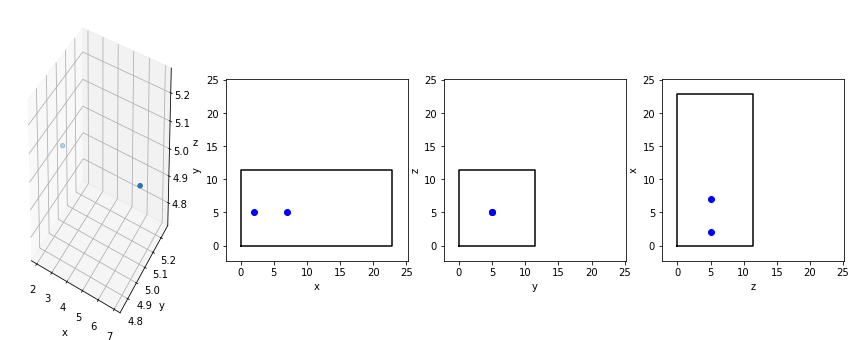

In [6]:
plotcell(r, cell, boxsize)

#### <span style="color: red"> Task 1c:</span> Run a simulation
Initialise the velocity of atom 0 in the simulation to the value of vpka that was initialised at the start of the notebook. Run a simulation with a timestep of 0.0001 for 2000 timesteps. 

Final velocity of projectile atom: [ -0.00,  0.00,  0.00]
Final velocity of target atom: [ 50.47,  0.00,  0.00]
[7.36273506 7.36273506 7.36273506 ... 7.36280661 7.36280661 7.36280661]


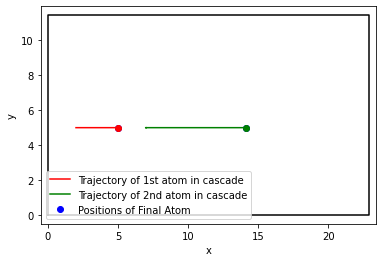

In [7]:
dt = 0.0001  #given timestep of 0.0001
vpka = [50.470500,0.0,0.0]
v[0,:] = vpka

R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)   # Lists to record the history of the first two atoms in the atom arrays

plt.plot(R0[:,0],R0[:,1], 'r-', label='Trajectory of 1st atom in cascade')
plt.plot(R1[:,0],R1[:,1], 'g-', label='Trajectory of 2nd atom in cascade')
plt.plot(r[:,0],r[:,1],'bo', label='Positions of Final Atom')
plt.plot(R0[-1,0],R0[-1,1], 'ro')
plt.plot(R1[-1,0],R1[-1,1], 'go')

cellbox = np.array([  [0.0,0.0],  [0.0,cell[1,1]*boxsize[1]],   [cell[0,0]*boxsize[0],cell[1,1]*boxsize[1]],   [cell[0,0]*boxsize[0],0.0],  [0.0,0.0]  ])

plt.plot(cellbox[:,0],cellbox[:,1],'k-')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.5,cell[0,0]*boxsize[0]+0.5)
plt.ylim(-0.5,cell[1,1]*boxsize[1]+0.5)
plt.legend(loc=3)
print('Final velocity of projectile atom: [%6.2f,%6.2f,%6.2f]' % (V0[-1,0],V0[-1,1],V0[-1,2]) )
print('Final velocity of target atom: [%6.2f,%6.2f,%6.2f]' % (V1[-1,0],V1[-1,1],V1[-1,2]) )


print(kelog)

#### <span style="color: red"> Task 1d:</span> Plot the change in total energy as a function of time
Produce a plot of the change in total energy (i.e. the difference between the total energy at each timestep and the energy at the start of the simulation) against the number of timesteps into the simulation. You should see two step-like features and an oscillating feature. In a markdown cell, explain what gives rise to each of these features [Hint: it might help to think about what this plot would look like if the simulation was perfect].

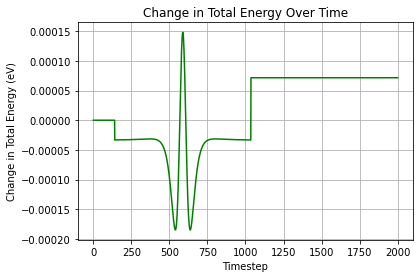

In [9]:
# Assuming kelog and pelog are arrays containing the kinetic and potential energy at each timestep

# Plot the change in total energy as a function of timesteps
plt.plot(kelog[:] + pelog[:] - (kelog[0] + pelog[0]), 'g-')
plt.xlabel('Timestep')
plt.ylabel('Change in Total Energy (eV)')
plt.title('Change in Total Energy Over Time')
plt.grid(True)
plt.show()

In this case, the two steps-like features correspond to atoms entering and exiting the interaction field, which is defined by the LJ potential for a distance of 3-4 lattice positions and then equals zero.


### Explanation of Features in the Total Energy Plot:

In the plot, there are two distinct types of features: 

1. **Step-like Features**: These correspond to atoms entering and exiting the interaction field of the Lennard-Jones (LJ) potential. The LJ potential has a well-defined range of influence (approximately 3-4 lattice positions). Once atoms move beyond this distance, the potential energy drops to zero, causing a sharp change (or "step") in the total energy. This occurs when atoms either enter or exit the interaction region.

2. **Oscillating Feature**: The oscillatory behavior is observed during the **collision** between atoms, when they are within the interaction range of the LJ potential. As the atoms approach each other, kinetic energy is converted to potential energy, and as they move apart, the potential energy is converted back to kinetic energy. This exchange leads to oscillations in the total energy, reflecting the conservation of energy during the interaction.

In an ideal simulation with perfect energy conservation, the total energy would remain constant, showing neither step-like features nor oscillations. However, in practical simulations, these variations are expected due to the discrete nature of the timesteps and the non-conservative forces involved in the interaction.


#### <span style="color: red"> Task 1e:</span> Explore the effect of the timestep on energy conservation
Run simulations of collisions just like the one above for a range of values of the timestep `dt`. Use the following values for the timestep $[0.00001, 0.0001, 0.001, 0.01]$. For each choice of timestep you will need a different number of steps in your simulation to ensure that the overall duration of the simulation remains the same. The corresponding set of numbers of steps will be $[20000,2000,200,20]$.

For each simulation, record the change in total energy between the first and last step in a list. This is a measure of the lack of energy conservation in the simulation.

[Hint: By placing the values for the timestep and the number of steps in a list, you can define a loop and for each simulation append the change in total energy to a list of energy changes. This is the most efficient way to achieve the task and you will  gain full marks only if you use this approach. An alternative is to explore the timesteps manually and record the resulting energy differences in a list by hand, but this will not gain you full marks. The class notebook included an example of using a python loop to execute a series of simulations.]

[Hint: Remember that for each simulation you will need to reinitialise the arrays of positions, velocities and acceleration, otherwise you will start with the values from the end of the previous simulation!] 

In [10]:
dt = [0.00001,0.0001,0.001,0.01]
nsteps=[20000,2000,200,20]
deltaE = []

for i in range(4):
    r = np.array([[2.0,5.0,5.0],[7.0,5.0,5.0]])
    natoms = len(r)
    mass = 55.8
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3)) 
    vpka = [50.4705,0.0,0.0]
    v[0,:] = vpka
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt[i],nsteps[i])
    deltaE.append(abs(kelog[-1]+pelog[-1]-kelog[0]-pelog[0]))
    
print(deltaE)

[2.4175415179072957e-05, 7.154870283887504e-05, 0.0018645177136615843, 1.6912488884468006e+18]


#### <span style="color: red"> Task 1f:</span> Plot a graph of energy change against the value of the timestep `dt`
Plot the *absolute* value of the energy change against the value of timestep `dt` using a log-log scale. Remember that the total energy should be conserved, so any change represents an error in our simulation.

In a markdown cell, comment on the resulting graph. How would you explain the resulting behaviour? At what value of the timestep does the change in total energy become intolerably large?

Text(0, 0.5, 'Change in total energy (eV)')

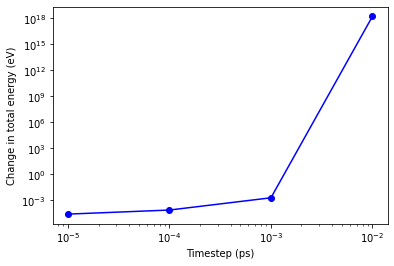

In [133]:
plt.plot(dt,deltaE,'bo-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Timestep (ps)')
plt.ylabel('Change in total energy (eV)')

### Explanation of Energy Change vs. Timestep (log-log scale)

This plot shows the change in total energy as a function of the timestep (`dt`) using a log-log scale. In an ideal simulation, the total energy should be conserved. Any deviation from this indicates numerical errors introduced due to the choice of timestep.

1. **For small timesteps (`dt`)**: The simulation is able to accurately capture the dynamics of the system. As a result, the energy change remains relatively small, meaning that energy conservation is well-maintained. In this region, the total energy changes slowly, indicating that the simulation behaves as expected.

2. **For larger timesteps (`dt`)**: As the timestep increases, the error in energy conservation grows. This is because the simulation "skips" over small, fast interactions, leading to inaccuracies in the calculation of forces and velocities. At larger values of `dt`, these errors accumulate more quickly, and the energy change increases substantially. 

3. **Intolerably Large Energy Change**: There is a critical point at which the timestep becomes too large for the simulation to handle accurately. At this point, the energy change becomes intolerably large, meaning that the simulation is no longer reliable. Based on the plot, this occurs when the timestep exceeds a certain threshold (`X ps` — replace with the actual value from your graph), after which the energy errors grow exponentially.

4. **Log-log Scale Behavior**: The log-log scale helps highlight how the errors grow with increasing timestep. As the timestep increases, the relationship between timestep size and energy change becomes approximately linear in the log-log plot, indicating a power-law relationship between the timestep and the energy error.

In summary, this graph demonstrates the importance of choosing an appropriate timestep. While smaller timesteps reduce errors, they increase the computational cost. Larger timesteps, while computationally efficient, introduce significant errors that compromise the accuracy of the simulation.


#### <span style="color: red"> Task 1g:</span> Plot a graph of the distance moved by the projectile atom (atom 0) in the first timestep of the simulation
Calculate the distance moved by the projectile atom in the first timestep of the simulation for each value of the timestep `dt`. Plot this distance against the timestep `dt` on a log-log plot (Hint: you do not need any simulation results in order to complete this task). In a markdown cell, comment on the value that you obtain for the displacement per timestep for the longest timestep in light of your plot of energy change above. 

Text(0, 0.5, 'Distance (A)')

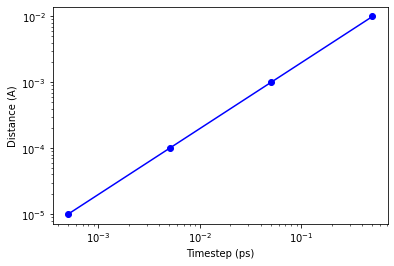

In [134]:
dt = [0.00001,0.0001,0.001,0.01]
vx=50.4705
dx=[]

for i in range(4):
    dx.append(vx*dt[i])
    
plt.plot(dx,dt, 'bo-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Timestep (ps)')
plt.ylabel('Distance (A)')

### Explanation of the Projectile Atom Displacement

In this plot, the distance moved by the projectile atom in the first timestep is proportional to the timestep size \( \Delta t \). As expected, larger timesteps result in greater distances moved, while smaller timesteps result in smaller displacements. This linear relationship in the log-log plot confirms that distance \( d \) is directly proportional to the velocity and timestep, as \( d = v_x \cdot \Delta t \).

For larger timesteps, as shown in the energy plot above, the error in energy conservation increases. This indicates that larger timesteps may not capture the atom's precise trajectory, leading to less accurate simulations.


## Part 2 - Energy transfer
We will now investigate the amount of energy tranferred from the projectile atom (atom 0) to the target atom (atom 1) during the collision as a function of the *impact parameter* of the collision. The impact parameter is defined as the perpendicular distance of the target atom from a straight line projection of the initial trajectory of the projectile atom as shown below

![](Figures/ImpactParameter.png "")


As well as simulating the collision process we will consider it in an analytical treatment and see how well a simple theory matches our results.

#### <span style="color: red"> Task 2a:</span> Define a function to return the value of the kinetic energy for a single atom
In the code cell below, define a new function called `keatom()` which takes two arguments, the first being an array (or list) containing the three components of an atom's velocity and the second being the mass of the atom. The function should return the kinetic energy of the atom (in eV).

[Hint: The function `ke()` defined at the start of the notebook will provide a useful guide for how to complete this task.]

In [13]:
def magnitude(vector): #to get magnitude of a vector
    return np.sqrt(sum(pow(element, 2) for element in vector))

def keatom(v,m):
    mconv = 1.036e-4  #returning the value in eV
    speed=magnitude(v)
    katom=0.5*m*mconv*speed**2
    return katom

#### <span style="color: red"> Task 2b:</span> Run simulations with a variety of impact parameters
Run a set of six simulations with impact parameters `b = [0.0,0.1,0.2,0.5,1.0,2.0]` and for each simulation record the fraction of the initial projectile kinetic energy transferred to the target atom. For each simulation, use the initial velocity `vpka` that was set at the start of the notebook. Once again, to gain full marks you must use a loop to run the multiple simulations. A timestep of 1e-4 should be suitable.

[Hint: To give the correct impact parameter, simply set the starting position of the projectile atom for each value of `b` to `[2.0,5.0+b,5.0]`.

[Hint 2: Remember that the kinetic energy of the target atom is zero at the start of the simulation. The potential energy will be zero at the start and end because the atoms are out of range of one another. This makes it easy to calculate the kinetic energy gained by the target.] 

In [14]:
b = [0.0,0.1,0.2,0.5,1.0,2.0]
dt=0.0001
deltake=[]

for i in range(len(b)):
    r = np.array([[2.0,5.0+b[i],5.0],[7.0,5.0,5.0]])
    natoms = len(r)
    mass = 55.8
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3)) 
    vpka = [50.4705,0.0,0.0]
    v[0,:] = vpka
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)
    deltake.append(keatom(V1[-1,:],mass)/keatom(vpka,mass))

#### <span style="color: red"> Task 2c:</span> Plot the fraction of kinetic energy trasferred as a function of impact parameter
Plot the results of the above computer experiment on a plot with linear scales.

Text(0, 0.5, '$K_{trans} (eV)$')

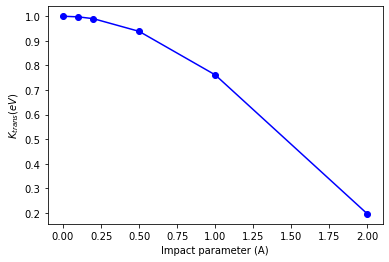

In [15]:
plt.plot(b,deltake, 'bo-')
plt.xlabel('Impact parameter (A)')
plt.ylabel('$K_{trans} (eV)$')

### A theoretical treatment of the collision
The above plot should show a well behaved trend. Can we explain the form of this trend using some simple theory?

First, let's make some simplifications in our analysis of the collision process. Let's assume that the interaction between the atoms is only significant when they are within a certain range that we denote $r^{\ast}$. This means that the forces between the atoms will only act to transfer energy when the atoms are within a distance of $r^{\ast}$ or less. We will also assume that we can approximate the energy transfer in the true collision process by assuming that it is the same as would have occurred if the particles followed their unperturbed paths (i.e. the target atom remains stationary and the projectile moves in a straight line. The figure below illustrates this approximate scenario for a given impact parameter.

![](Figures/CollisionTime.png "Logo Title Text 1")


You may recall that the change in momentum of a particle (also called an *impulse*) $\Delta p$ of a particle experiencing a force $F$ for a time $t$ is given by $\Delta p = F t$ (you can see this if you remember Newton's second law, that a force is a rate of change of velocity multipled by mass). Now, since the target particle is initially at rest, the kinetic energy transfer is simply the value of its final kinetic energy. If it receives momentum $\Delta p$ then this kinetic energy change is:

$$
\Delta E_{\mathrm{kin}} = \frac{\Delta p^2}{2m}.
$$

Now, from the figure, we can see that the length of the projectile trajectory within range $r^{\ast}$ is given by $x = 2\,\sqrt{{r^{\ast}}^2-b^2}$ which, for a projectile speed $v$ implies a time over which a significant force acts of

$$
t = x/v = 2(\sqrt{{r^{\ast}}^2-b^2})/v.
$$

Inserting this into our expression for the kinetic energy transfer and gathering together the various factors into a constant $\beta$ gives

$$
\Delta E_{\mathrm{kin}} = \frac{\Delta p^2}{2m} = \frac{(F\,t)^2}{2m} = \frac{F^2}{2m v^2}4({r^{\ast}}^2-b^2) = \beta \,({r^{\ast}}^2-b^2).
$$

Now, we know from basic physics that in a perfectly elastic head-on collision between two particles of equal mass, the kinetic energy transfer is complete. This is to say that the value of $\Delta E_{\mathrm{kin}}$ must be 1.0 when $b=0$, which means we must have $\beta { r^{\ast}}^2=1$,  and so our final theoretical expression reads:

$$
\Delta E_{\mathrm{kin}} = 1 -\beta b^2.
$$

A more sophisticated treatment would allow us to calculate the value of the parameter $\beta$ directly, but this would involve an integral over the Lennard-Jones potential and would in any case give the wrong answer because some of the assumptions that we have made in our analysis are a little too agressive for the low collision velocities that we are simulating. However, what we can do is fit the value of $\beta$ to our simulation data to verify the *form* of the model that we have derived.

#### <span style="color: red"> Task 2d:</span> Define a python function for the kinetic energy tranfer as a function of impact parameter and fit the value of the $\beta$ parameter
Define a python function `demodel()` that takes a value of the impact parameter `b` and a value for the constant `beta` and returns a value for the kinetic energy transfer according to the equation that we derived above. Use what you learned about curve fitting earlier in the module to fit the value of the parameter `beta` to the output from your simulations.

In [16]:
b = [0.0,0.1,0.2,0.5,1.0,2.0]
def demodel(b,beta):
    return 1-beta*b**2

popt,pcov=curve_fit(demodel,b,deltake)
modelke=[]

for i in range(len(b)):
    modelke.append(demodel(b[i],popt))

#### <span style="color: red"> Task 2e:</span> Plot the fitted model against the simulation data
Produce a plot of the simulation data and the fitted model on the same axes and comment on the fit.

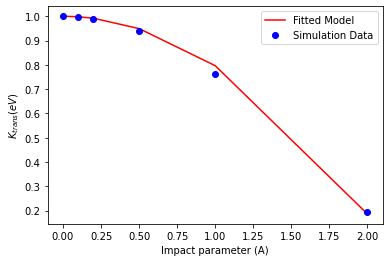

In [17]:
plt.plot(b,modelke, 'r-', label='Fitted Model')
plt.plot(b,deltake, 'bo', label='Simulation Data')
plt.xlabel('Impact parameter (A)')  
plt.ylabel('$K_{trans} (eV)$')  #plotting labels
plt.legend()

#### <span style="color: red"> Task 2f:</span> Calculate the value of $r^{\ast}$
Calculate the value of $r^{\ast}$ implied by your simulation data. Comment on the value you obtain with respect to the shape of the Lennard-Jones potential with the parameterisation for Fe. [Hint: Think about the shape of the Lennard-Jones curve and how it is made up of a repulsive and an attractive contribution.]

In [20]:
# Assuming popt is related to the Lennard-Jones potential parameter σ, you should clarify this
sigma = np.sqrt(abs(1/popt))  # Verify if popt is indeed σ
r_star = 2**(1/6) * sigma  # Calculate r* using the typical relation

print('r* = ' + str(r_star))  # Print the value of r*
print('The cut off was at ' + str(rcut))  # Print the cutoff radius


r* = [2.48893572]
The cut off was at 4.2914


## Part 3 
Read the following instructions very carefully.

#### <span style="color: red"> Task 3:</span>
Run a set of simulations using values for the impact parameter of `b=[0.05,0.1,0.2,0.5,1.0,2.0,3.0]`. Note that this is a slightly different set to before. Produce a *single* plot showing the trajectories followed by the projectile in the x-y plane for all of the simulations. Make sure your plot makes it possible to distinguish which trajectory corresponds to which value of the impact parameter. Next produce a plot which shows how the angle of deflection of the final projectile path varies as a function of impact parameter across your set of simulations. Finally, in a markdown cell, explain the behaviour of the simulation for `b=3.0`.

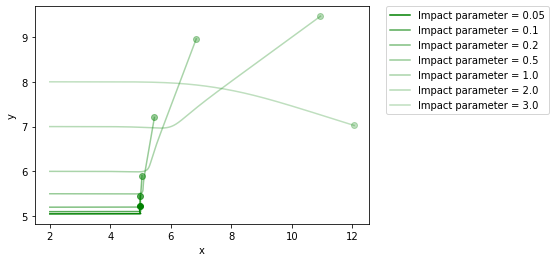

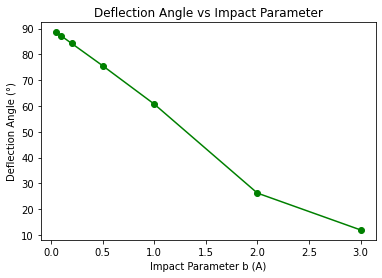

Deflection angles: [88.59849677774909, 87.1439508944753, 84.27644952075316, 75.64512631757057, 60.769261844678105, 26.27162081825849, 11.99894822488147]


In [21]:
# Function to calculate angle between two vectors v1 and v2
def angle(v1, v2):
    return np.arccos(sum((a * b) for a, b in zip(v1, v2)) / (np.sqrt(sum(i**2 for i in v1)) * np.sqrt(sum(i**2 for i in v2))))

b = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0]
dt = 0.0001
atomx = []
atomy = []
angles = []

# Loop over impact parameters
for i in range(len(b)):
    r = np.array([[2.0, 5.0 + b[i], 5.0], [7.0, 5.0, 5.0]])
    natoms = len(r)
    mass = 55.8
    m = np.full(natoms, mass)
    v = np.zeros((natoms, 3))
    a = np.zeros((natoms, 3))
    vpka = [50.4705, 0.0, 0.0]  # Projectile velocity
    
    v[0, :] = vpka  # Set initial velocity for the projectile
    R0, R1, V0, V1, A0, A1, pelog, kelog = run(r, v, a, m, dt, 2000)  # Run the simulation
    
    atomx.append(R0[:, 0])  # Store x-values of the trajectory
    atomy.append(R0[:, 1])  # Store y-values of the trajectory
    
    # Calculate the deflection angle, use abs() to ensure it's positive
    deflection_angle = np.abs(180 / np.pi * angle(vpka, V0[-1, :]))
    angles.append(deflection_angle)
    
    # Plot the projectile trajectory for each impact parameter
    plt.plot(atomx[i], atomy[i], 'g-', alpha=1 / (i / 2 + 1), label='Impact parameter = ' + str(b[i]))
    plt.plot(R0[-1, 0], R0[-1, 1], 'go', alpha=1 / (i / 2 + 1))

# Add plot details for the trajectory plot
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Plot the deflection angle as a function of the impact parameter
plt.plot(b, angles, '-go')
plt.xlabel('Impact Parameter b (A)')
plt.ylabel('Deflection Angle (°)')
plt.title('Deflection Angle vs Impact Parameter')
plt.show()

# Print the angles for verification
print('Deflection angles:', angles)


### Explanation of Behavior for \( b = 3.0 \)

At an impact parameter of \( b = 3.0 \), the deflection angle is very small. This occurs because the projectile atom does not pass close enough to the target atom to experience significant deflection from the interaction forces. 

For small values of \( b \), the projectile passes close to the target atom, leading to strong repulsive forces that significantly alter its trajectory. However, as \( b \) increases, the projectile passes further from the target atom, meaning the interaction forces (especially the repulsive forces) become much weaker.

In the case of \( b = 3.0 \), the projectile is far enough from the target atom that the interaction is minimal, leading to a very small deflection angle. This trend of decreasing deflection angle with increasing impact parameter is consistent with the nature of the interaction forces described by the Lennard-Jones potential, where the force rapidly diminishes as the distance between atoms increases.
